# ZDT1

## Imports

In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd

import bofire.strategies.api as strategies
from bofire.benchmarks.api import ZDT1
from bofire.data_models.domain.api import Domain
from bofire.data_models.kernels.api import RBFKernel
from bofire.data_models.priors.api import (
    HVARFNER_NOISE_PRIOR,
    DimensionalityScaledLogNormalPrior,
)
from bofire.data_models.strategies.api import MoboStrategy, RandomStrategy
from bofire.data_models.surrogates.api import (
    BotorchSurrogates,
    SaasSingleTaskGPSurrogate,
    SingleTaskGPSurrogate,
)
from bofire.runners.api import run
from bofire.utils.multiobjective import compute_hypervolume, get_pareto_front


SMOKE_TEST = os.environ.get("SMOKE_TEST")

N_ITERATIONS = 50 if not SMOKE_TEST else 1
BATCH_SIZE = 5 if not SMOKE_TEST else 1
WARMUP_STEPS = 256 if not SMOKE_TEST else 32
NUM_SAMPLES = 128 if not SMOKE_TEST else 16
THINNING = 16

## Random Optimization

In [ ]:
def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled


def hypervolume(domain: Domain, experiments: pd.DataFrame) -> float:
    return compute_hypervolume(domain, experiments, ref_point={"y1": 1.0, "y2": 5.0})


random_results = run(
    ZDT1(n_inputs=30),
    strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=domain)),
    n_iterations=N_ITERATIONS,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 1.555: 100%|██████████| 50/50 [00:01<00:00, 36.85it/s]


## Optimization with Hvarfner priors

In [ ]:
benchmark = ZDT1(n_inputs=30)


def strategy_factory(domain: Domain):
    data_model = MoboStrategy(
        domain=domain,
        ref_point={"y1": 1.0, "y2": 5.0},
        surrogate_specs=BotorchSurrogates(
            surrogates=[
                SingleTaskGPSurrogate(
                    inputs=benchmark.domain.inputs,
                    outputs=benchmark.domain.outputs.get_by_keys(["y1"]),
                    # the following hyperparams do not need to be provided
                    kernel=RBFKernel(
                        ard=True, lengthscale_prior=DimensionalityScaledLogNormalPrior()
                    ),
                    noise_prior=HVARFNER_NOISE_PRIOR(),
                ),
                SingleTaskGPSurrogate(
                    inputs=benchmark.domain.inputs,
                    outputs=benchmark.domain.outputs.get_by_keys(["y2"]),
                    # the following hyperparams do not need to be provided
                    kernel=RBFKernel(
                        ard=True, lengthscale_prior=DimensionalityScaledLogNormalPrior()
                    ),
                    noise_prior=HVARFNER_NOISE_PRIOR(),
                ),
            ]
        ),
    )
    return strategies.map(data_model)


results = run(
    ZDT1(n_inputs=30),
    strategy_factory=strategy_factory,
    n_iterations=N_ITERATIONS,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 4.378: 100%|██████████| 50/50 [06:07<00:00,  7.34s/it]


## Optimization with default priors

In [ ]:
benchmark = ZDT1(n_inputs=30)


def strategy_factory(domain: Domain):
    data_model = MoboStrategy(
        domain=domain,
        ref_point={"y1": 1.0, "y2": 5.0},
    )
    return strategies.map(data_model)


results = run(
    ZDT1(n_inputs=30),
    strategy_factory=strategy_factory,
    n_iterations=N_ITERATIONS,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 2.331: 100%|██████████| 50/50 [09:56<00:00, 11.92s/it]


## SAASBO Optimization

In [ ]:
benchmark = ZDT1(n_inputs=30)


def strategy_factory(domain: Domain):
    data_model = MoboStrategy(
        domain=domain,
        ref_point={"y1": 1.0, "y2": 5.0},
        surrogate_specs=BotorchSurrogates(
            surrogates=[
                SaasSingleTaskGPSurrogate(
                    inputs=benchmark.domain.inputs,
                    outputs=benchmark.domain.outputs.get_by_keys(["y1"]),
                    # the following hyperparams do not need to be provided
                    warmup_steps=WARMUP_STEPS,
                    num_samples=NUM_SAMPLES,
                    thinning=THINNING,
                ),
                SaasSingleTaskGPSurrogate(
                    inputs=benchmark.domain.inputs,
                    outputs=benchmark.domain.outputs.get_by_keys(["y2"]),
                    # the following hyperparams do not need to be provided
                    warmup_steps=WARMUP_STEPS,
                    num_samples=NUM_SAMPLES,
                    thinning=THINNING,
                ),
            ]
        ),
    )
    return strategies.map(data_model)


results = run(
    ZDT1(n_inputs=30),
    strategy_factory=strategy_factory,
    n_iterations=N_ITERATIONS,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 4.578: 100%|██████████| 50/50 [1:32:20<00:00, 110.81s/it]


Plot the pareto front.

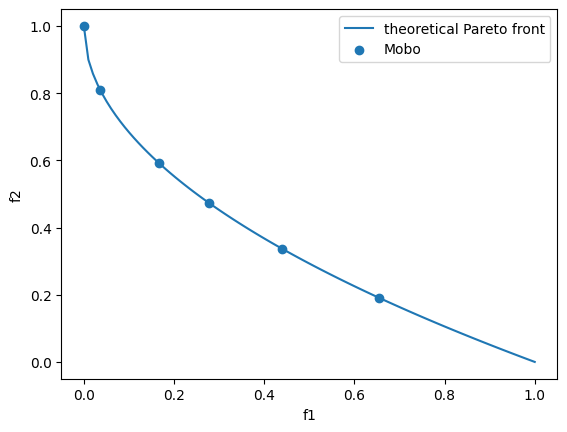

In [ ]:
theoretical_front = benchmark.get_optima()
front = get_pareto_front(domain=benchmark.domain, experiments=results[0][0])

fig, ax = plt.subplots()
ax.plot(theoretical_front.y1, theoretical_front.y2, label="theoretical Pareto front")

ax.scatter(front.y1, front.y2, label="Mobo")
ax.set_xlabel("f1")
ax.set_ylabel("f2")


ax.legend()

plt.show()

Show the performance of the optimizer.

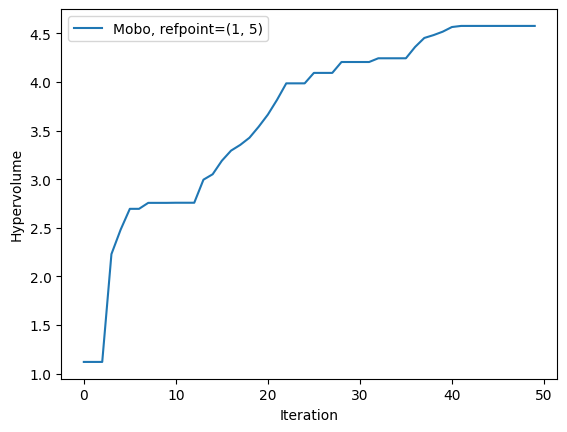

In [ ]:
fig, ax = plt.subplots()

ax.plot(results[0][1], label="Mobo, refpoint=(1, 5)")

ax.set_ylabel("Hypervolume")
ax.set_xlabel("Iteration")

ax.legend()